На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:
•	В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
•	Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.


In [171]:
!pip install pingouin

   ---------------------------------------- 0.0/204.4 kB ? eta -:--:--
   ------- ------------------------------- 41.0/204.4 kB 991.0 kB/s eta 0:00:01
   ---------------------------------- ----- 174.1/204.4 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 204.4/204.4 kB 2.5 MB/s eta 0:00:00


In [59]:
import pandas as pd
import numpy as np

import pingouin as pg
from scipy.stats import levene
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

from scipy.stats import shapiro, kruskal
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

In [17]:
mpl.style.use('ggplot')

•	id – id клиента в эксперименте
•	group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
•	events – сколько блюд суммарно было заказано за период

In [7]:
df = pd.read_csv('5_task_1.csv')
df.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.3+ KB


In [13]:
df.group.unique()

array(['A', 'B', 'C'], dtype=object)

<Axes: xlabel='group', ylabel='events'>

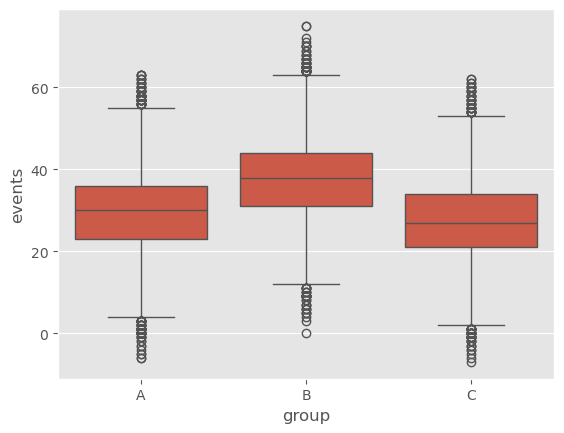

In [15]:
sns.boxplot(x='group', y='events', data=df)

Проверка Гомогенности дисперсий внутри групп

In [41]:
group_A = df[df['group'] == 'A'].sample(1000)['events']
group_B = df[df['group'] == 'B'].sample(1000)['events']
group_C = df[df['group'] == 'C'].sample(1000)['events']

In [43]:
levene(group_A, group_B, group_C)

LeveneResult(statistic=0.35734264687140027, pvalue=0.6995625649795423)

In [ ]:
pvalue - большой,  что указывает на принятие нулевой гипотезы о равенстве дисперсий внутри групп(их гомогенности).

In [45]:
#Сравнение средних в представленных группах
group_A_mean = df[df['group'] == 'A']['events'].mean()
group_B_mean = df[df['group'] == 'B']['events'].mean()
group_C_mean = df[df['group'] == 'C']['events'].mean()
print(f' Средние значения в представленных группах: \n group_A_mean = {group_A_mean} \n group_B_mean = {group_B_mean} \n group_C_mean = {group_C_mean}')

 Средние значения в представленных группах: 
 group_A_mean = 29.5796 
 group_B_mean = 37.6136 
 group_C_mean = 27.4703


<Axes: xlabel='group', ylabel='events'>

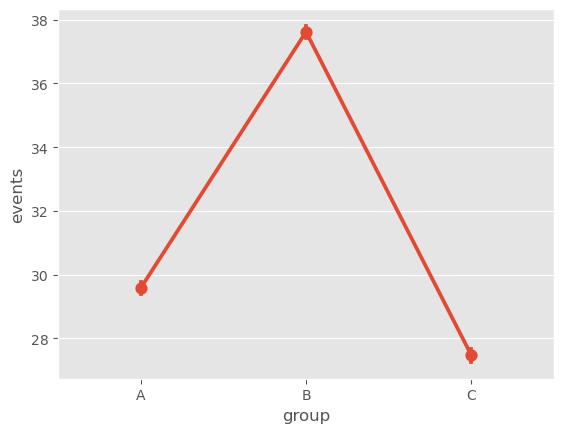

In [47]:
sns.pointplot(x='group', y='events', data=df)

In [49]:
#Проверка нормальности распределений
pg.normality(data=df, dv="events", group="group", method="normaltest")

,W,pval,normal
group,,,
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


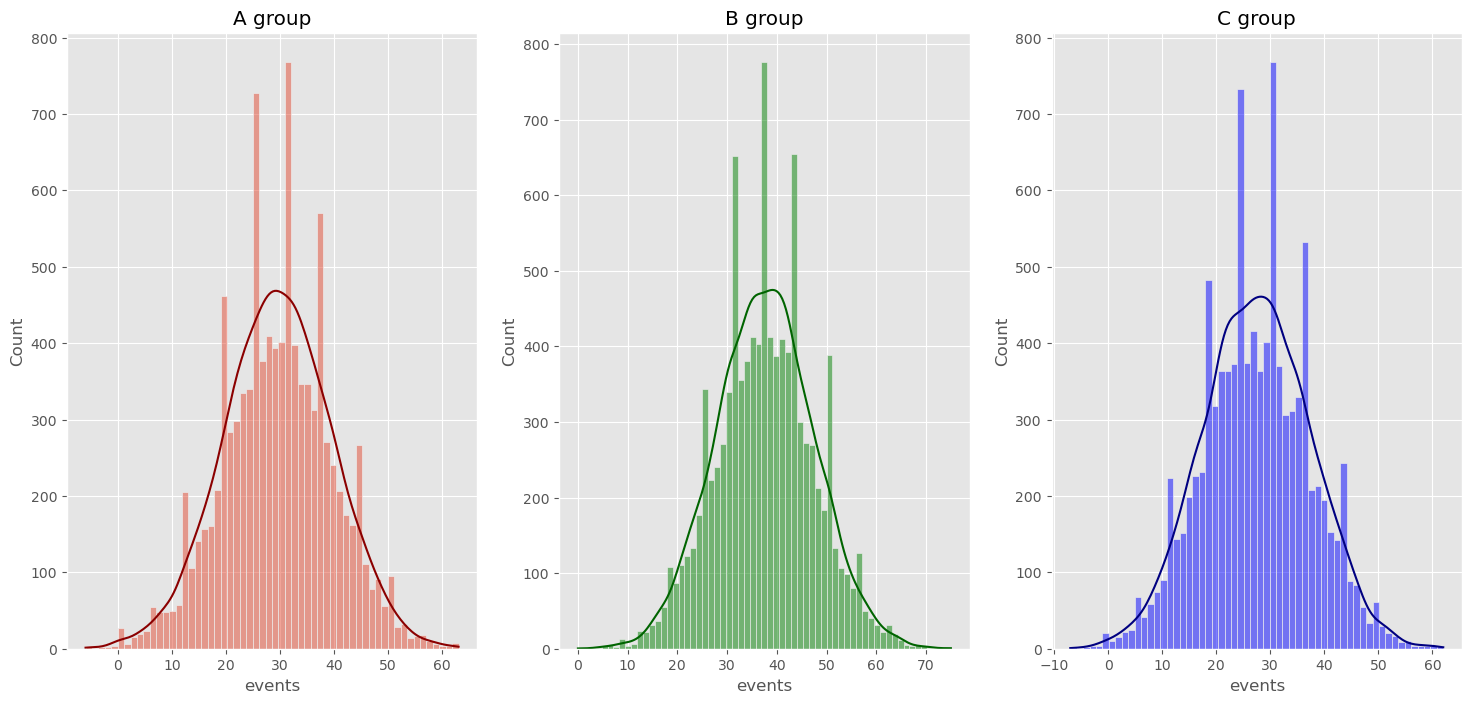

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

sns.histplot(df.query('group == "A"').events, kde=True,ax=axes[0]).lines[0].set_color('#8B0000')
axes[0].set_title('A group')
sns.histplot(df.query(' group == "B"').events, kde=True, color='green', ax=axes[1]).lines[0].set_color('#006400')
axes[1].set_title('B group')
sns.histplot(df.query(' group == "C"').events, kde=True, color='blue', ax=axes[2]).lines[0].set_color('#000080')
axes[2].set_title('C group')

plt.show()

In [57]:
pg.anova(data=df, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [53]:
#Используем критерий Тьюки для определения между какими группами есть статистически значимые различия
pg.pairwise_tukey(data=df, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


In [55]:
# В данном случае проверку эту выполнять не нужно, просто чекаю.
pg.pairwise_tests(data=df, dv='events', between='group', padjust="holm")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,7.500262e-50,holm,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,1.024138


Исходя из полученных результатов, делаем вывод, что все три наши группы имеют значимые различия в своих данных. Опираясь на средние значения заказов в отдельных группах, даем рекомендацию использовать изображения, как у группы B – квадратные/

•	id – id клиента в эксперименте
•	segment – сегмент (high/low)
•	group – вид кнопки (control – старая версия, test – новая верси

Судя по нашим данным, можем сказать, что нам потребуется многофакторный дисперсионный анализ.)


In [9]:
df2 = pd.read_csv('5_task_2.csv')
df2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


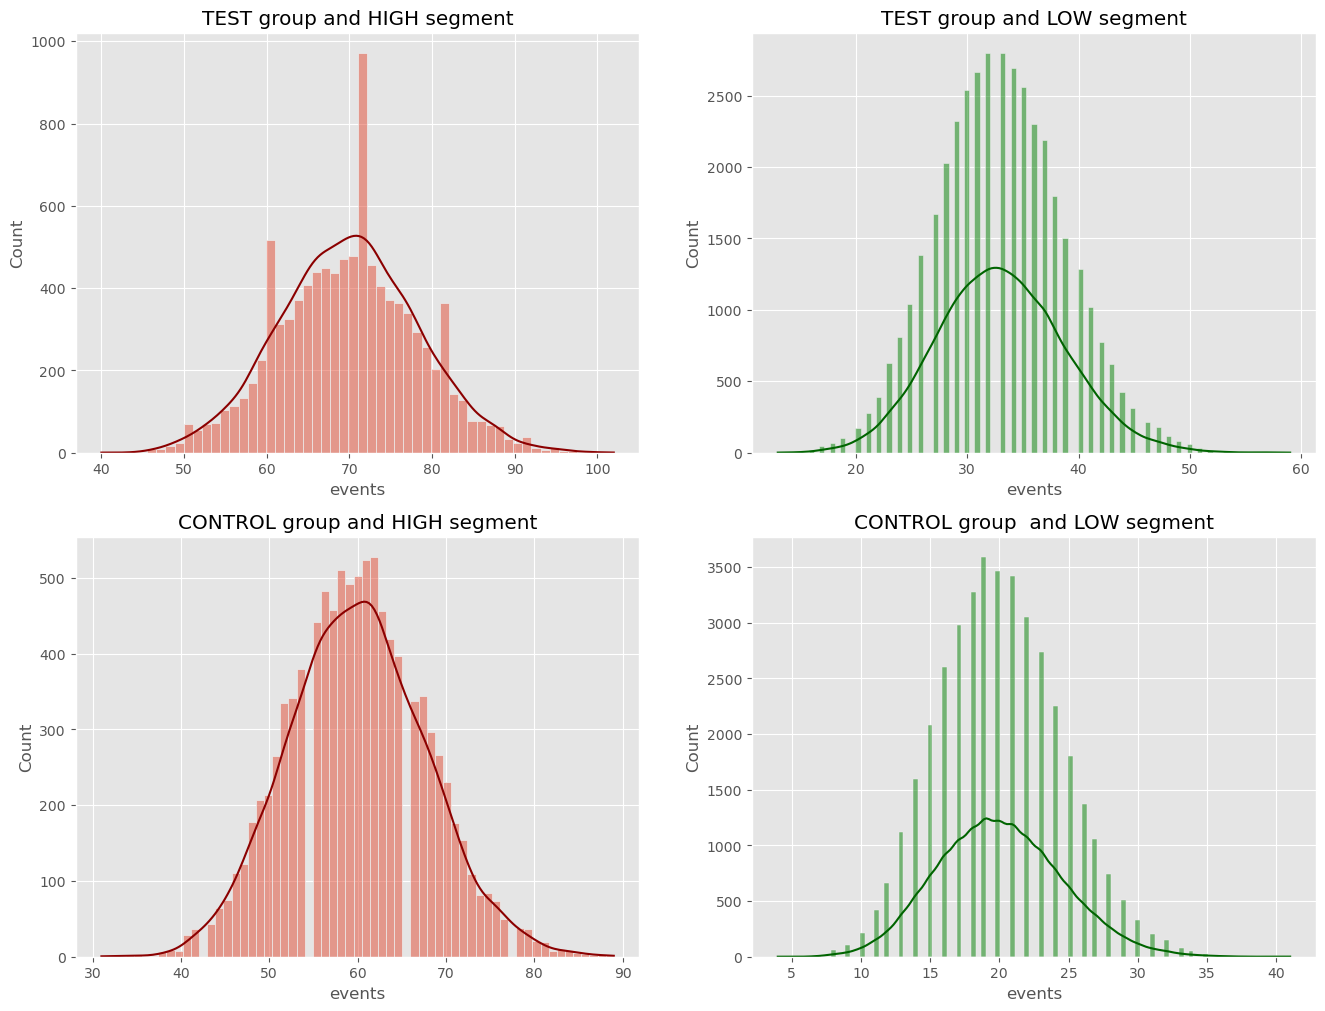

In [19]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(df2.query('group == "test" and segment == "high"').events, kde=True, ax=axes[0,0]).lines[0].set_color('#8B0000')
axes[0,0].set_title('TEST group and HIGH segment')

sns.histplot(df2.query('group == "test" and segment == "low"').events, kde=True, color='green', ax=axes[0,1]).lines[0].set_color('#006400')
axes[0,1].set_title('TEST group and LOW segment')


sns.histplot(df2.query(' group == "control" and segment == "high"').events, kde=True, ax=axes[1,0]).lines[0].set_color('#8B0000')
axes[1,0].set_title('CONTROL group and HIGH segment')

sns.histplot(df2.query('group == "control" and segment == "low"').events, kde=True, color='green', ax=axes[1,1]).lines[0].set_color('#006400')
axes[1,1].set_title('CONTROL group  and LOW segment')

plt.show()

In [21]:
#Описательные характеристики
df2.groupby(['group', 'segment']).events.describe().T.round(2)

group     control                test          
segment      high       low      high       low
count    10000.00  40000.00  10000.00  40000.00
mean        59.97     20.03     69.94     33.03
std          7.81      4.47      8.40      5.72
min         31.00      4.00     40.00     13.00
25%         55.00     17.00     64.00     29.00
50%         60.00     20.00     70.00     33.00
75%         65.00     23.00     76.00     37.00
max         89.00     41.00    102.00     59.00

In [ ]:
ПЕРЕЙДЕМ К МНОГОФАКЬТОРНОМУ АНАЛИЗУ

In [37]:
#Проверка требования к гомогенности дисперсий наших групп
group_A = df2.query('group == "test" and segment == "high"').events
group_B = df2.query('group == "test" and segment == "low"').events
group_C = df2.query(' group == "control" and segment == "high"').events
group_D = df2.query('group == "control" and segment == "low"').events
levene(group_A, group_B, group_C, group_D)

LeveneResult(statistic=2983.609682903818, pvalue=0.0)

In [ ]:
Дисперсии не гомогенны

In [57]:
for name, group in df2.groupby(['group', 'segment']):
    stat, p_value = shapiro(group['events'].sample(5000))
    print(f'Группа: {name}, p-значение: {p_value}')
    if p_value > 0.05:
        print('Данные, вероятно, нормальны')
    else:
        print('Данные, вероятно, не нормальны')

Группа: ('control', 'high'), p-значение: 1.1568493495705466e-06
Данные, вероятно, не нормальны
Группа: ('control', 'low'), p-значение: 2.427031065470572e-17
Данные, вероятно, не нормальны
Группа: ('test', 'high'), p-значение: 2.394208941813072e-05
Данные, вероятно, не нормальны
Группа: ('test', 'low'), p-значение: 1.6019440021529433e-10
Данные, вероятно, не нормальны


Попробуем провести логарифмическое преобразование данных в колонке EVENTS  и снова проверим группы на нормальность и гомогенность

In [67]:
df2['log_events'] = np.log(df2['events'])

In [69]:
stat, p_value = levene(
    df2[df2['group'] == 'test']['log_events'],
    df2[df2['group'] == 'control']['log_events']
)
print(f'p-значение Левене: {p_value}')

p-значение Левене: 0.0


In [71]:
for name, group in df2.groupby(['group', 'segment']):
    stat, p_value = shapiro(group['log_events'].sample(5000))
    print(f'Группа: {name}, p-значение: {p_value}')
    if p_value > 0.05:
        print('Данные, вероятно, нормальны')
    else:
        print('Данные, вероятно, не нормальны')

Группа: ('control', 'high'), p-значение: 1.569131450241392e-12
Данные, вероятно, не нормальны
Группа: ('control', 'low'), p-значение: 6.038004825822407e-23
Данные, вероятно, не нормальны
Группа: ('test', 'high'), p-значение: 8.556152894796566e-15
Данные, вероятно, не нормальны
Группа: ('test', 'low'), p-значение: 7.388506395162584e-18
Данные, вероятно, не нормальны


Логарифмирование данных не произвело ожидаемого результата, поэтому применим Непараметрический аналог ANOVA: тест Краскела-Уоллиса. Непараметрического многофакторного теста не существует, поэтому проведем отдельные тесты внутри Segment и group, а так же их взаимодействие.

In [81]:
for segment in df2['segment'].unique():
    subset = df2[df2['segment'] == segment]
    stat, p = kruskal(
        subset[subset['group'] == 'test']['events'],
        subset[subset['group'] == 'control']['events']
    )
    print(f'Segment: {segment}, p-значение: {p}')

Segment: high, p-значение: 0.0
Segment: low, p-значение: 0.0


In [83]:
for group in df2['group'].unique():
    subset = df2[df2['group'] == group]
    stat, p = kruskal(
        subset[subset['segment'] == 'high']['events'],
        subset[subset['segment'] == 'low']['events']
    )
    print(f'Group: {group}, p-значение: {p}')

Group: test, p-значение: 0.0
Group: control, p-значение: 0.0


In [ ]:
Анализ взаимодействий — сравниваем внутри уровней segment по group

In [85]:
# Внутри сегмента 'high'
high_test = df2[(df2['segment'] == 'high') & (df2['group'] == 'test')]['events']
high_control = df2[(df2['segment'] == 'high') & (df2['group'] == 'control')]['events']

stat, p_value = kruskal(high_test, high_control)
print(f'В сегменте "high", различия между группами: p-значение = {p_value}')

В сегменте "high", различия между группами: p-значение = 0.0


# Внутри сегмента 'low'
low_test = df2[(df2['segment'] == 'low') & (df2['group'] == 'test')]['events']
low_control = df2[(df2['segment'] == 'low') & (df2['group'] == 'control')]['events']

stat, p_value = kruskal(low_test, low_control)
print(f'В сегменте "low", различия между группами: p-значение = {p_value}')

ЕСли бы выборки оказались нормальными и гомогенными, то все это в одну строчку через АНОВА и затем через папарное сравнение  в критерии Тьюки:

In [281]:
pg.anova(data=df2, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377485,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [296]:
#Проведем тест Тьюки для того, чтобы узнать между какими гурппами есть стат значимые различия, СПОЙЛЕР - МЕЖДУ ВСЕМИ.
df2['combo'] = df2.segment + '-' + df2.group

In [298]:
MultiComparison(df2.events, df2.combo).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
high-control,high-test,9.9677,0.0,9.7551,10.1803,True
high-control,low-control,-39.9392,0.0,-40.1073,-39.7711,True
high-control,low-test,-26.9449,0.0,-27.113,-26.7768,True
high-test,low-control,-49.9069,0.0,-50.075,-49.7388,True
high-test,low-test,-36.9126,0.0,-37.0807,-36.7445,True
low-control,low-test,12.9944,0.0,12.888,13.1007,True


<Axes: xlabel='group', ylabel='events'>

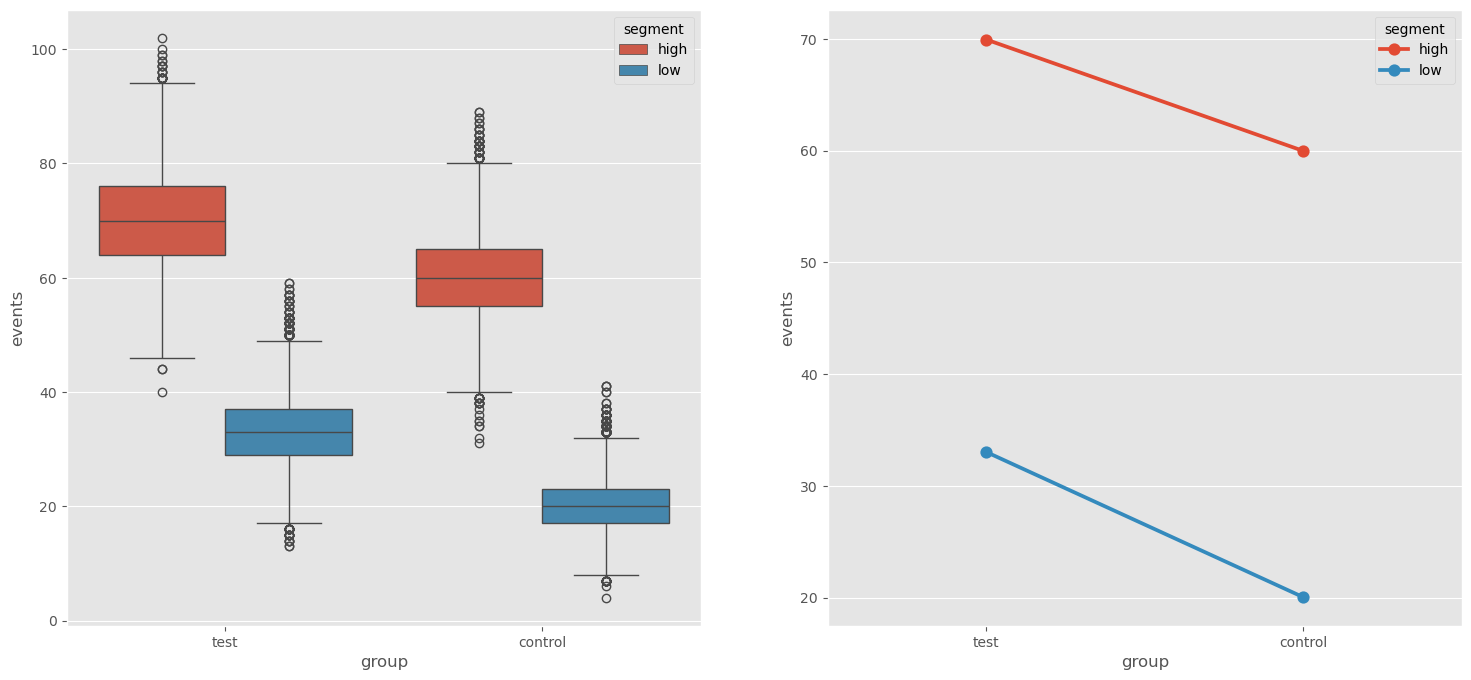

In [302]:
#ЕЩЕ РАЗ ВИЗУАЛИЗИРУЕМ НАШИ ДАННЫЕ
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.boxplot(data=df2, x='group', y='events', hue='segment', ax=axes[0])
sns.pointplot(data=df2, x='group', y='events', hue='segment', ax=axes[1])

Фактор group оказался ЗНАЧИМЫМ, фактор segment – ЗНАЧИМЫМ, их взаимодействие – ЗНАЧИМО. Судя по графику, для всех групп среднее значение events УВЕЛИЧИЛОСЬ, поэтому решение: ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ.